# Poverty in Marseille with granular data

In [3]:
import requests
import tempfile
import zipfile
import os
import re
import py7zr
import pandas as pd
import geopandas
from shapely.ops import transform
from shapely.geometry import Polygon, Point
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

from pynsee.geodata.get_geodata import get_geodata

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [ ]:
# download data from insee.fr
url = "https://www.insee.fr/fr/statistiques/fichier/4176290/Filosofi2015_carreaux_200m_csv.zip"

def _download_data(url=url):
    results = requests.get(url, verify=False)
    dirpath = tempfile.mkdtemp()
    dwnFile = dirpath + '\\datafile'

    if not os.path.exists(dwnFile):
        with open(dwnFile, 'wb') as f:
            f.write(results.content)
            f.close()

    with zipfile.ZipFile(dwnFile, 'r') as zip_ref:
        zip_ref.extractall(dirpath)

    file_to_read = [f for f in os.listdir(dirpath) if not re.match('.*.zip$', f)]
    file_to_load = dirpath + "/" + file_to_read[0]

    with py7zr.SevenZipFile(file_to_load, mode='r') as z:
        z.extractall(dirpath)

    file_to_read = [f for f in os.listdir(dirpath) if re.match('.*metropole.csv$', f)]
    file_to_load = dirpath + "/" + file_to_read[0]
    data = pd.read_csv(file_to_load, dtype='str', sep=",")

    return data

data = _download_data()

/home/tfardet/.virtualenvs/pynsee/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.insee.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
def _extract_lat_lon(string, pattern = "CRS3035RES200mN"):
    """function to extract latitude and longitude from data""" 
    
    splitted_string = re.sub(pattern, "", string).split("E")
    lat_lon_numeric = [int(x) for x in splitted_string] 
    return lat_lon_numeric

def _make_square(string, sideLength = 200):
    """function to make square from geographical points"""    
    
    lat, lon = _extract_lat_lon(string)
    polygon = Polygon([Point(lon, lat), 
                      Point(lon + sideLength, lat),
                      Point(lon + sideLength, lat + sideLength),
                      Point(lon, lat + sideLength),
                      Point(lon, lat)])
    return polygon

In [ ]:
# filter data on Var departement
data13 = data[data.Depcom.str.contains('^13')].reset_index(drop=True)

In [ ]:
# make geographical squares
data13 = gpd.GeoDataFrame(
    data13,
    geometry=data13["IdINSPIRE"].apply(lambda x: _make_square(x)),
    crs="EPSG:3035"
)

In [2]:
# download geographical data from IGN API
arr = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_municipal', crs="EPSG:3035")

NameError: name 'get_geodata' is not defined

In [1]:
# filter geographical limits of Marseille city
marseille = arr[arr.nom.str.contains("Marseille")]

geoMarseille = marseille.union_all()

dataMarseille = data13.iloc[
    data13.sindex.query(geoMarseille, predicate="intersects")
].reset_index(drop=True)

geoMarseille

NameError: name 'arr' is not defined

In [9]:
# compute percentage of poor households for each 200m square 
cols = ["Men_pauv", "Men"]
dataMarseille[cols] = dataMarseille[cols].apply(pd.to_numeric, errors='coerce')
dataMarseille["Men_pauv_pct"] = dataMarseille["Men_pauv"] / dataMarseille["Men"] * 100

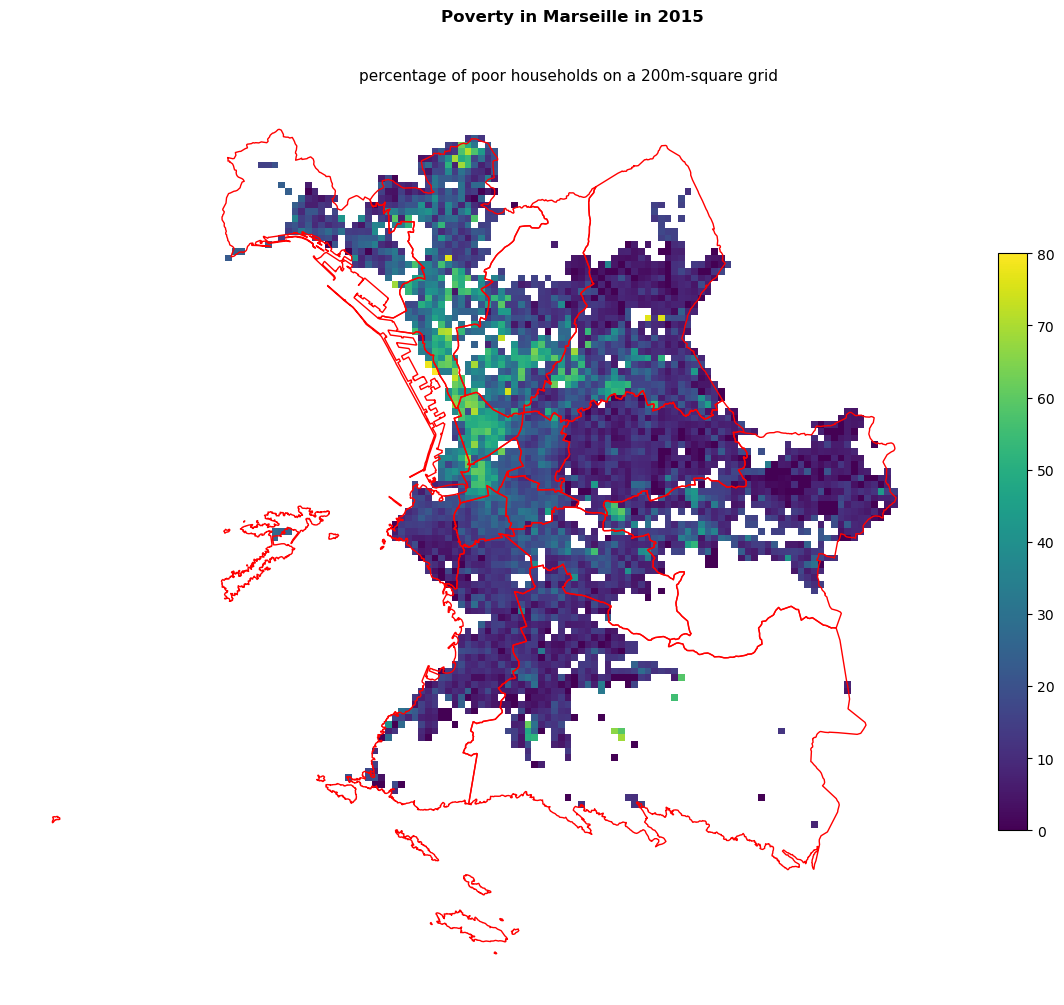

In [10]:
# make plot
ax = dataMarseille.plot(column='Men_pauv_pct', 
                           cmap=cm.viridis, 
                           legend=True,
                           legend_kwds={'shrink': 0.5},
                           figsize = (15,15))
marseille.plot(ax=ax, edgecolor='red', color='none')
ax.set_axis_off()
plt.suptitle('Poverty in Marseille in 2015', y=0.85, fontweight="bold")
plt.title('percentage of poor households on a 200m-square grid', size=11, x=0.6)
plt.show()